# PART 1 - Machine Learning

## Task 1.1 - Data Preparation
There are 100 rows and 11 dimensions in the dataset. The data is 100% dense. Feature labels were added.

Task is to predict the number of containers a ship can carry. 
The target is known hence this is supervised learning.

From the inputs we want to get a output of the weighted sum : 𝑦 = 𝑓(𝑥𝑤)

- Import necessary modules and Read data and add feature names
- Call the head method to get a general overview of the data

In [22]:
#Import required modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
try:
    cols = ["IMO_NO.", "Vessel_Name", "Year_Built", "Gross_Tonnage", "Deadweight_Tonnage", "Length", "Beam", "Capacity_(TEU)", "Forward_Bays", "Center_Bays", "Aft_Bays"]
    data = pd.read_csv('containers.csv',names=cols)
    display(data.head())
except Exception as e:
    print("There was an error loading the file, make sure it is in root: ",e)

,IMO_NO.,Vessel_Name,Year_Built,Gross_Tonnage,Deadweight_Tonnage,Length,Beam,Capacity_(TEU),Forward_Bays,Center_Bays,Aft_Bays
0,9260421,ANNA MAERSK,2003,93496,109000,352.60,42.80,8272,15,0,6
1,9461867,APL CHONGQING,2011,113735,122200,349.00,45.73,10106,15,0,5
2,9354404,BF EUPHORIA,2006,9962,11432,134.44,22.74,868,8,0,0
3,9343728,BREMEN EXPRESS,2008,93750,103567,335.06,42.87,8749,15,0,5
4,9314947,CAMELLIA,2006,28927,39200,222.15,30.04,2824,11,0,2


- **Explore the data**

Our first step is to summarize & explore the DataFrame by  computing aggregations. We can do this by using the info method in Pandas. We can see that all data is non-null as expected, and we have 8 numeric values, one target, and one String.

In [23]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMO_NO.             100 non-null    int64  
 1   Vessel_Name         100 non-null    object 
 2   Year_Built          100 non-null    int64  
 3   Gross_Tonnage       100 non-null    int64  
 4   Deadweight_Tonnage  100 non-null    int64  
 5   Length              100 non-null    float64
 6   Beam                100 non-null    float64
 7   Capacity_(TEU)      100 non-null    int64  
 8   Forward_Bays        100 non-null    int64  
 9   Center_Bays         100 non-null    int64  
 10  Aft_Bays            100 non-null    int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 8.7+ KB


,IMO_NO.,Year_Built,Gross_Tonnage,Deadweight_Tonnage,Length,Beam,Capacity_(TEU),Forward_Bays,Center_Bays,Aft_Bays
count,1.000000e+02,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,9.457695e+06,2009.29000,103460.380000,107838.850000,313.804100,46.033200,9721.430000,10.980000,3.760000,3.790000
std,2.645332e+05,7.05003,60777.083352,57016.601909,71.138278,26.519082,6079.659143,3.074759,5.140687,1.640984
min,8.201648e+06,1982.00000,6191.000000,7979.000000,127.940000,19.200000,686.000000,6.000000,0.000000,0.000000
25%,9.310704e+06,2006.00000,55350.250000,67245.000000,278.455000,36.055000,5002.750000,8.000000,0.000000,4.000000
50%,9.446524e+06,2010.00000,94209.500000,104034.000000,332.675000,45.620000,8641.000000,11.000000,0.000000,4.000000
75%,9.687781e+06,2014.00000,149213.500000,150710.500000,366.155000,51.060000,13938.000000,14.000000,10.000000,5.000000
max,9.869186e+06,2021.00000,232311.000000,232606.000000,400.000000,286.670000,23964.000000,17.000000,14.000000,10.000000


**Finding outliers and inconsistent data** 

For each of these features above, comparing the max and 75% values, we can start to see a huge difference in the Beam (Width) feature. This confirms that there may be an error with some of the tuples. 

**Duplicate Vessel Identification Number (IMO)**

Now lets count the vessel identification number, which should be unique for the given dataset, however we can easily spot a duplicate IMO vessel. An online search shows that this vessel was renamed/purchased, we will leave in this duplicate vessel. IMO No. 9314947 in the dataset.

Let us investigate further.

In [24]:
print(data['IMO_NO.'].value_counts())

IMO_NO.
9314947    2
9260421    1
9298997    1
9454436    1
9631981    1
          ..
9619438    1
9618276    1
9444273    1
9236470    1
9795610    1
Name: count, Length: 99, dtype: int64


Let’s have a quick look at the distribution of the Beam feature by plotting a histograms, this will show us the vessel with the incorrect width.

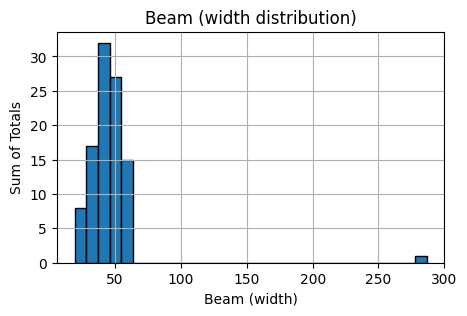

In [25]:

# for col in data.iloc[:,2:11]:
data['Beam'].hist(figsize=(5, 3), bins=30, edgecolor="black", )
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.title('Beam (width distribution)')
plt.xlabel('Beam (width)')
plt.ylabel("Sum of Totals")
plt.show()

**Fix the outlier**

Here we can see one ship has a length and width of 300x290 meters. I've never seen a square vessel before, probably doesn't go very fast!  The outlier is identified as MSC Albany with IMO 9619438. Correct beam should be 48meters. (https://www.vesselfinder.com/vessels/details/9619438) Since we have good reason to believe this is factually incorrect data it would be appropriate to correct the Beam to 48 meters

In [26]:
# Find the outlier as index 32, width cannot be the same as the length of the ship.
print(data.loc[32])

IMO_NO.                  9619438
Vessel_Name           MSC ALBANY
Year_Built                  2013
Gross_Tonnage              94017
Deadweight_Tonnage        112516
Length                    299.18
Beam                      286.67
Capacity_(TEU)              8886
Forward_Bays                  14
Center_Bays                    0
Aft_Bays                       4
Name: 32, dtype: object


- Clean the data

In [27]:
corrected_beam_MSC_Albany = 48
edited_data = data.copy()
edited_data.at[32,'Beam'] = corrected_beam_MSC_Albany
edited_data.loc[32]
edited_data

,IMO_NO.,Vessel_Name,Year_Built,Gross_Tonnage,Deadweight_Tonnage,Length,Beam,Capacity_(TEU),Forward_Bays,Center_Bays,Aft_Bays
0,9260421,ANNA MAERSK,2003,93496,109000,352.60,42.80,8272,15,0,6
1,9461867,APL CHONGQING,2011,113735,122200,349.00,45.73,10106,15,0,5
2,9354404,BF EUPHORIA,2006,9962,11432,134.44,22.74,868,8,0,0
3,9343728,BREMEN EXPRESS,2008,93750,103567,335.06,42.87,8749,15,0,5
4,9314947,CAMELLIA,2006,28927,39200,222.15,30.04,2824,11,0,2
...,...,...,...,...,...,...,...,...,...,...,...
95,9776418,CMA CGM ANTOINE DE SAINT EXUPERY,2018,217673,202684,400.00,59.00,20776,7,13,4
96,9863340,HMM HELSINKI,2020,228283,232606,399.90,61.00,23964,7,13,4
97,9868352,HMM STOCKHOLM,2020,232311,229039,399.90,61.50,23820,7,13,4
98,9778820,MILAN MAERSK,2017,214286,190326,399.00,58.60,20568,6,13,5


**Split the data (training & testing)**

- 75% Training data (Default)
- 25% Testing data (Default)
- A high training  set of 75% will prevent overfitting*
  underfitting is too simple
- Shuffle the data

By default train_test_split method shuffles the Dataframe randomly prior to splitting, hence we do not need to shuffle beforehand. Shuffling the data ensures that there are no patterns or structure in the order of the data that could *bias the results* of the model. It also ensures that both the training and testing dataset contains a good generalization of the model and is representative of the overall distribution of the vessel data.

In [28]:
from sklearn.model_selection import train_test_split
X = edited_data.copy() # Copy prevents mutation of the original dataset incase we need to revert changes.
y = edited_data['Capacity_(TEU)'].copy() # Prevents mutation.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
X_Test_With_All_Columns = X_test.copy() # Keep a copy of the X_Test before dropping columns & Normalization below

# Log the number of training and testing data, you can see 75% for training,a nd 25% for testing.
print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)



(75, 11) (25, 11) (75,) (25,)


Drop features that are not required to train the model, such as the target variable and the IMO_NO & Vessel_Name in order to lower dimension. 


In [29]:
cols_to_drop = ['IMO_NO.','Vessel_Name','Capacity_(TEU)']
X_train.drop(columns=cols_to_drop, axis=1, inplace=True) #Dropped cols
X_test.drop(columns=cols_to_drop, axis=1, inplace=True) #Dropped Cols

print(len(X_train)) # 75% Training data
print(len(X_test)) # 25% Testing data

75
25


**Feature Scaling using MinMaxScaler (Normalization)**

Now let us normalize the data to ensure that the values share a common scale, this will reduce complexity and optimize the data for machine learning. In this case we will use the StandardScaler

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_X_Train = scaler.fit_transform(X_train)
scaled_X_Test = scaler.fit_transform(X_test)


 Our data is now loaded, normalized, split and prepared for modelling.

## TASK 1.2 REGRESSION

**Pipelines**

We will be training our model on 3 regression algorithm's mentioned below. In order to efficiently load the models, we can use *make_pipeline from sklearn.pipeline*.

- Random Forest (Decision Trees)
- Multi Layer Perceptron  (MLP)
- Support Vector Regression

In [31]:
# Load the required dependencies
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

* Set up pipelines for each algorithm

In [32]:
from sklearn.pipeline import make_pipeline

# Store all the pipeline inside a dictionary.
pipelines = {
    'Random_Forest': make_pipeline(RandomForestRegressor(random_state=0)),
    'Multi_Layer_Perceptron' : make_pipeline(MLPRegressor(random_state=0)), # Early stopping prevents generalization, stops when predictions get worse
    'Support_Vector_Regression' : make_pipeline(SVR())
}

Each of the 3 algorithms contain tunable hyperparameters, instead of manually tuning parameter for our dataset, we can utilize sklearn GridSearchCV. 

GridSearchCV provides a exhaustive search *(2-10 mins depending on CPU power)* on our predefined parameters for each algorithm. This returns the best possible combination of hyperparameters for each of our 3 algorithms used.

In [33]:

# Set up a hyperparameter grid, the model will go through each of the parameters one by one in order to find the best convergence.

hyper_param_grid = {
    'Random_Forest': {
        'randomforestregressor__n_estimators':[50,100,200]
    },
    'Multi_Layer_Perceptron' : {
        'mlpregressor__hidden_layer_sizes':[50,100],
        'mlpregressor__solver':['adam','lbfgs'],
        'mlpregressor__max_iter':[100,500,2000]
    },
    'Support_Vector_Regression': {
        'svr__kernel':['sigmoid','linear','poly'],

    }    
}

- Start Training

Import Grid Search CV and run the pipelines to fit the models on the training data

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError 
import warnings #Import python warning package
from sklearn.exceptions import ConvergenceWarning # Disable Convergence Warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

fit_model = {} #Dictionary that holds our models

for algo,pipeline in pipelines.items():
    try:
        model = GridSearchCV(pipeline,hyper_param_grid[algo], verbose=4,cv=5) #Logging & Cross Validation, uses a scoring of r2 by default
        print('Training started for',algo,'...')
        model.fit(scaled_X_Train,y_train.values)
        fit_model[algo] = model

        print (algo, 'has been fitted! 👏')
        print ("========================================")
    except NotFittedError as e:
        print ("Error detected")
        print(repr(e))

print("All Training has been completed!! 👏👏")

Training started for Random_Forest ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END randomforestregressor__n_estimators=50;, score=0.986 total time=   0.0s
[CV 2/5] END randomforestregressor__n_estimators=50;, score=0.985 total time=   0.0s
[CV 3/5] END randomforestregressor__n_estimators=50;, score=0.996 total time=   0.0s
[CV 4/5] END randomforestregressor__n_estimators=50;, score=0.985 total time=   0.0s
[CV 5/5] END randomforestregressor__n_estimators=50;, score=0.977 total time=   0.0s
[CV 1/5] END randomforestregressor__n_estimators=100;, score=0.987 total time=   0.1s
[CV 2/5] END randomforestregressor__n_estimators=100;, score=0.987 total time=   0.1s
[CV 3/5] END randomforestregressor__n_estimators=100;, score=0.996 total time=   0.1s
[CV 4/5] END randomforestregressor__n_estimators=100;, score=0.984 total time=   0.1s
[CV 5/5] END randomforestregressor__n_estimators=100;, score=0.981 total time=   0.1s
[CV 1/5] END randomforestregressor__n_estimato

We have now completed training! Lets output the best scores, best model and best params for each algorithm (based on training data)

In [39]:
# Output the best scores for each Algorithm, for this we are using the default of R2.
print("R2 SCORE FOR EACH REGRESSION")
print("----------------------------\n")
print("Random Forest : ", fit_model['Random_Forest'].best_score_)
print("MLP : ", fit_model['Multi_Layer_Perceptron'].best_score_)
print("SVR : ",fit_model['Support_Vector_Regression'].best_score_)

# Output the best possible parameters for each Algorithm
print("\nBEST HYPER PARAMETERS FOR EACH MODEL")
print("----------------------------------\n")
print(fit_model['Random_Forest'].best_params_)
print(fit_model['Multi_Layer_Perceptron'].best_params_)
print(fit_model['Support_Vector_Regression'].best_params_)

print("\nBEST HYPER PARAMETERS FOR EACH MODEL")
print("----------------------------------\n")

# Print the best estimator, this is the best hyperparmeters
print("Best estimator:", fit_model['Random_Forest'].best_estimator_)
print("Best estimator:", fit_model['Multi_Layer_Perceptron'].best_estimator_)
print("Best estimator:", fit_model['Support_Vector_Regression'].best_estimator_)


R2 SCORE FOR EACH REGRESSION
----------------------------

Random Forest :  0.9866910434783772
MLP :  0.9902669495465763
SVR :  0.4724182100296055

BEST HYPER PARAMETERS FOR EACH MODEL
----------------------------------

{'randomforestregressor__n_estimators': 100}
{'mlpregressor__hidden_layer_sizes': 50, 'mlpregressor__max_iter': 100, 'mlpregressor__solver': 'lbfgs'}
{'svr__kernel': 'poly'}

BEST HYPER PARAMETERS FOR EACH MODEL
----------------------------------

Best estimator: Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(random_state=0))])
Best estimator: Pipeline(steps=[('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=50, max_iter=100,
                              random_state=0, solver='lbfgs'))])
Best estimator: Pipeline(steps=[('svr', SVR(kernel='poly'))])


Based on the above metrics, can deduce the following. (Final output may be differ due to random splitting, shuffling)

- Best Model in terms of R^2 score for : Multi_Layer_Perceptron
- Best score achieved: 0.99~
- Best hyperparameters: {'mlpregressor__hidden_layer_sizes': 50, 'mlpregressor__max_iter': 100, 'mlpregressor__solver': 'lbfgs'}

*Note this is only based on TRAINING DATA* (Expect lower scores on testing data)

In [44]:
best_model = None
best_score = -1

for algo, model in fit_model.items():
    score = model.best_score_
    if score > best_score:
        best_model = algo
        best_score = score

print("Best model in terms of R^2 score:", best_model)
print("Best score achieved:", best_score)
print("Best hyperparameters:", fit_model[best_model].best_params_)

Best model in terms of R^2 score: Multi_Layer_Perceptron
Best score achieved: 0.9902669495465763
Best hyperparameters: {'mlpregressor__hidden_layer_sizes': 50, 'mlpregressor__max_iter': 100, 'mlpregressor__solver': 'lbfgs'}


### Top 10 Capacity Predictions using Test Data for all 3 models, ordered by Algorithm (Descending)

We can now use the above models with the best hyperparametrs to predict our unseen *TESTING DATA*


In [45]:
# Set up dictionary to hold all predictions and add them top a TOP10 dataframe
predictions = {}
Top10 = X_Test_With_All_Columns.loc[:,cols_to_drop]
for algo,pipeline in pipelines.items():
   predictions[algo] = fit_model[algo].predict(scaled_X_Test) # We now use our TESTING data to make predictions
   Top10[algo] = predictions[algo]

RandomForestSet = Top10.drop(["Multi_Layer_Perceptron","Support_Vector_Regression"],axis=1).sort_values('Random_Forest', ascending=False).reset_index(drop=True).head(10)
MLPSet = Top10.drop(["Random_Forest","Support_Vector_Regression"],axis=1).sort_values('Multi_Layer_Perceptron', ascending=False).reset_index(drop=True).head(10)
SVR = Top10.drop(["Random_Forest","Multi_Layer_Perceptron"],axis=1).sort_values('Support_Vector_Regression', ascending=False).reset_index(drop=True).head(10)
display(RandomForestSet, MLPSet, SVR)


,IMO_NO.,Vessel_Name,Capacity_(TEU),Random_Forest
0,9776418,CMA CGM ANTOINE DE SAINT EXUPERY,20776,22667.72
1,9695121,CSCL GLOBE,19100,20231.30
2,9454436,CMA CGM MARCO POLO,16022,19292.04
3,9869186,HMM GARAM,16010,14938.07
4,9728942,TAURUS,14354,14513.29
5,9467263,CSCL JUPITER,14074,14295.53
6,9612997,ANTWERPEN EXPRESS,13167,13566.88
7,9467392,MSC BERYL,12400,13525.38
8,9739680,MAERSK GENOA,10100,10627.52
9,9685334,MOL BRILLIANCE,10100,10356.47


,IMO_NO.,Vessel_Name,Capacity_(TEU),Multi_Layer_Perceptron
0,9776418,CMA CGM ANTOINE DE SAINT EXUPERY,20776,23794.312823
1,9695121,CSCL GLOBE,19100,19851.550387
2,9454436,CMA CGM MARCO POLO,16022,18622.419128
3,9869186,HMM GARAM,16010,17231.349542
4,9728942,TAURUS,14354,15550.591314
5,9467263,CSCL JUPITER,14074,14608.975734
6,9612997,ANTWERPEN EXPRESS,13167,13713.749209
7,9467392,MSC BERYL,12400,13004.102935
8,9739680,MAERSK GENOA,10100,12473.898724
9,9685334,MOL BRILLIANCE,10100,11857.038051


,IMO_NO.,Vessel_Name,Capacity_(TEU),Support_Vector_Regression
0,9776418,CMA CGM ANTOINE DE SAINT EXUPERY,20776,16777.286346
1,9695121,CSCL GLOBE,19100,14486.176823
2,9454436,CMA CGM MARCO POLO,16022,13503.326428
3,9869186,HMM GARAM,16010,13377.521755
4,9728942,TAURUS,14354,12303.528355
5,9467263,CSCL JUPITER,14074,11491.232034
6,9612997,ANTWERPEN EXPRESS,13167,11243.513833
7,9467392,MSC BERYL,12400,10810.529471
8,9739680,MAERSK GENOA,10100,9556.156001
9,9685334,MOL BRILLIANCE,10100,9347.694540


### Task 1.3 Assessment of regression on Testing Data

We can visualize the actual vs prediction values for all testing data for each regression by two methods.

- Using a easy to interpret line plot showing our predicted vs actual test data
- Use a Box plot summarize the distribution of models performance.

RANDOM_FOREST METRICS
R2 Score 0.9655717459172231
Mean Abs Pct Error: 0.08035991916167234
Mean Abs Error: 712.1224000000001
Mean Squared Error: 989014.3354000002


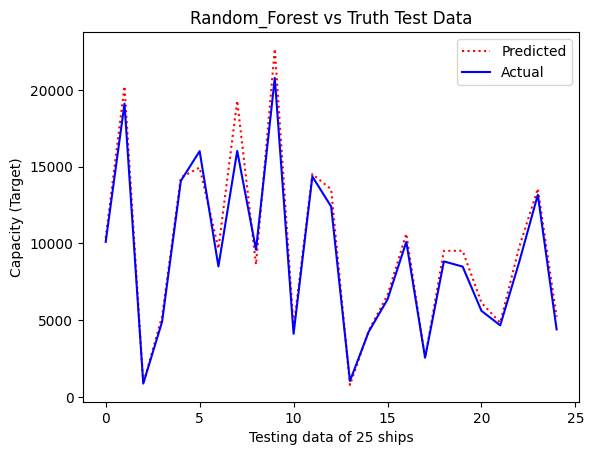

MULTI_LAYER_PERCEPTRON METRICS
R2 Score 0.9553095578121774
Mean Abs Pct Error: 0.10296753463307716
Mean Abs Error: 823.032119194314
Mean Squared Error: 1283814.3889856043


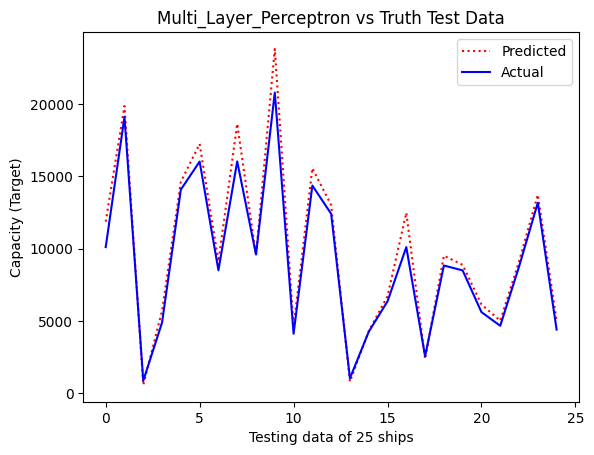

SUPPORT_VECTOR_REGRESSION METRICS
R2 Score 0.7083739482814747
Mean Abs Pct Error: 0.7995227622455026
Mean Abs Error: 2365.0325557120705
Mean Squared Error: 8377489.751070732


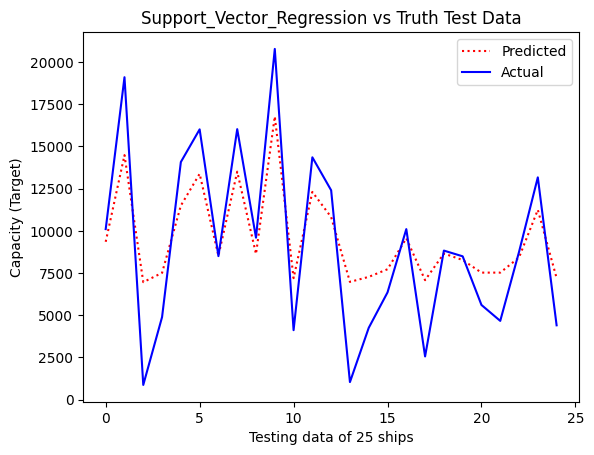

In [46]:
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
for algo in predictions:
    print(algo.upper() + " METRICS")
    print("R2 Score", + r2_score(y_test.values,predictions[algo])) # Best possible score is 1
    print("Mean Abs Pct Error:", + mean_absolute_percentage_error(y_test.values,predictions[algo])) # Mean absolute percentage error (MAPE) regression loss.
    print("Mean Abs Error:", + mean_absolute_error(y_test.values,predictions[algo])) #  Gives the mean of absolute difference between model prediction and target value. Lower the better
    print("Mean Squared Error:", + mean_squared_error(y_test.values,predictions[algo])) # Lower the better
    plt.plot(predictions[algo], "r:", label="Predicted")
    plt.plot( y_test.values, "b-", label="Actual")
    plt.legend()
    plt.title(algo + ' vs Truth Test Data')
    plt.xlabel("Testing data of 25 ships")
    plt.ylabel("Capacity (Target)")
    plt.show()
  


We can immediately notice that all the above metrics are lower/less accurate then the training data, this is expected as the testing data has not been seen by the trained model.

A better way would be to use Cross Validation and summarize the all 3 models using the best hyper parameters from the previous step. Then use a box plot to show the R2_Score & Mean Squared Error(MSE) for each model.
Using cross validation will prevent overfitting of the data.

Based on the results from GridSearchCV we know the best parameter are stored in *.best_esimator* method.

- Random Forest hyper parameters: {'randomforestregressor__n_estimators': 100}

- MLP hyper parameters: {'mlpregressor__hidden_layer_sizes': 50, 'mlpregressor__max_iter': 100, 'mlpregressor__solver': 'lbfgs'}

- SVR hyperparamers: {'svr__kernel': 'poly'}



### Box Plot showing R2 scores (Closer to 1.0 indicates a more accurate prediction)

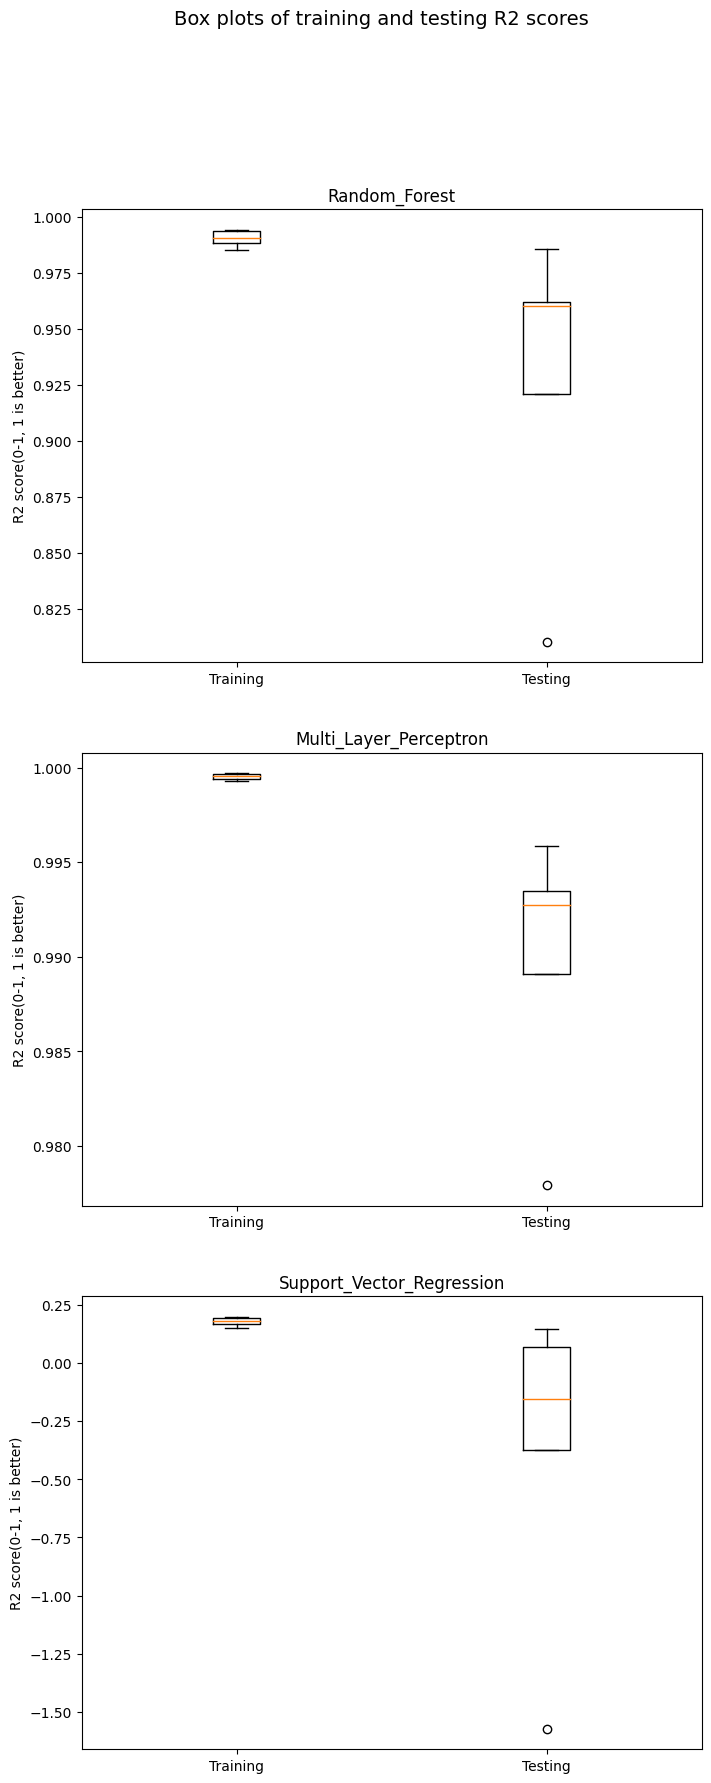

In [49]:
# Running cross validation for each models best metrics on testing data
 
from sklearn.model_selection import cross_validate
fig, axs = plt.subplots(len(fit_model), 1, figsize=(8, 20))
fig.suptitle('Box plots of training and testing R2 scores', fontsize=14)

# scoring = 'neg_mean_squared_error'
for i,algo in enumerate(fit_model):
    regression_model = fit_model[algo].best_estimator_ #Using the .best_estimator reached from the GridSearchCV fitting.
    cv_results = cross_validate(estimator=regression_model, X=scaled_X_Test, y=y_test, cv=5, scoring='r2' ,return_train_score=True)
    training = cv_results["train_score"]
    testing = cv_results["test_score"]
  
    axs[i].boxplot([training, testing], labels=['Training', 'Testing'])
    axs[i].set_title(algo) 
    axs[i].set_ylabel("R2 score(0-1, 1 is better)")
   
plt.show()




### Box Plot showing MSE scores (Lower scores are better)
We need to negate negative mean square error score as the scikit learn API assumes that all scoring metrics should be maximized.

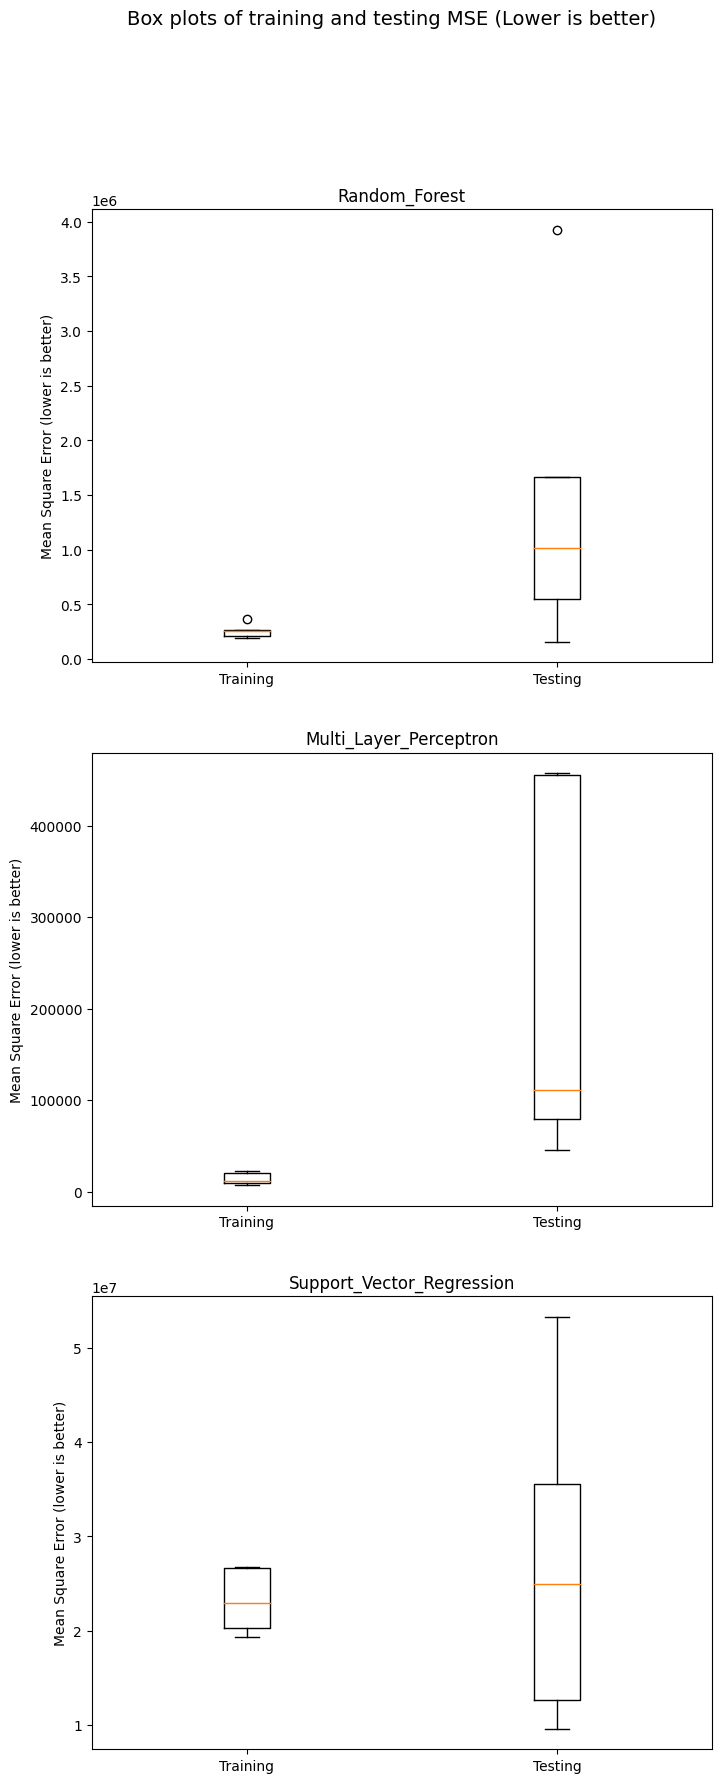

In [50]:
# Running cross validation for each models best metrics on testing data
 
from sklearn.model_selection import cross_validate
fig, axs = plt.subplots(len(fit_model), 1, figsize=(8, 20))
fig.suptitle('Box plots of training and testing MSE (Lower is better)', fontsize=14)

# scoring = 'neg_mean_squared_error'
for i,algo in enumerate(fit_model):
    regression_model = fit_model[algo].best_estimator_ #Using the .best_estimator reached from the GridSearchCV fitting.
    cv_results = cross_validate(estimator=regression_model, X=scaled_X_Test, y=y_test, cv=5, scoring='neg_mean_squared_error' ,return_train_score=True)
    training = - cv_results["train_score"]
    testing = - cv_results["test_score"]
    axs[i].boxplot([training, testing], labels=['Training', 'Testing'])
    axs[i].set_title(algo) 
    axs[i].set_ylabel("Mean Square Error (lower is better)")
   
plt.show()

## Summary 

We can see that our testing data results were not as accurate as our training data, this is as expected.  

Based on the mean MSE score, Support Vector Regression shows to have a closely matching mean to our Training data, this suggests that the model is neither overfitting or undefitting, i.e the model is able to generalize well to new unseen data. Random forest has a lower overall MSE indicating that the model performs better for the given testing data with a narrower whisker variance. 

Overall it is important to have multiple evaluation metrics to assess the model prediction. Multi Layer perceptron seemed to have the widest variance and despite the high R2 score, would probably not performance well on  larger dataset.